###  Introduction and Schema Diagram
The goal of this project is to practice SQL skills to answer business questions. The Chinook database is provided as a SQLite database file called chinook.db. A copy of the database schema is below

![Alt text](https://s3.amazonaws.com/dq-content/191/chinook-schema.svg)

### Overview of the Data

In [3]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

In [4]:
%%sql
SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table","view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


### Selecting New Albums to Purchase
Based on sales select 3 albumns from the most popular genres.

In [5]:
%%sql
WITH usa_tracks AS 
    (SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE country = "USA"
    )   
SELECT 
    g. name genre,
    COUNT(ut.track_id) tracks_sold,
    CAST(COUNT(ut.track_id) AS FLOAT)/(
            SELECT COUNT(*) FROM usa_tracks
            ) perct_sold
 FROM usa_tracks ut
 INNER JOIN track t ON t.track_id = ut.track_id
 INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;


Done.


genre,tracks_sold,perct_sold
Rock,561,0.5337773549000951
Alternative & Punk,130,0.12369172216936251
Metal,124,0.11798287345385347
R&B/Soul,53,0.05042816365366318
Blues,36,0.03425309229305423
Alternative,35,0.03330161750713606
Latin,22,0.02093244529019981
Pop,22,0.02093244529019981
Hip Hop/Rap,20,0.019029495718363463
Jazz,14,0.013320647002854425


In [6]:
%%sql
WITH usa_tracks AS 
    (SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE country = "USA"
    ) 
    
SELECT 
    ar.name artist_name,
    g.name genre,
    COUNT(ut.track_id) tracks_sold,
    CAST(COUNT(ut.track_id) AS FLOAT)/(
            SELECT COUNT(*) FROM usa_tracks
            ) perct_sold
 FROM usa_tracks ut
 INNER JOIN track t ON t.track_id = ut.track_id
 INNER JOIN genre g ON g.genre_id = t.genre_id
 INNER JOIN album a ON a.album_id = t.album_id
 INNER JOIN artist ar ON ar.artist_id = a.artist_id
WHERE g.name = "Rock"
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 1;

Done.


artist_name,genre,tracks_sold,perct_sold
Van Halen,Rock,43,0.04091341579448145


In [7]:
%%sql
WITH usa_tracks AS 
    (SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE country = "USA"
    ) 
    
SELECT 
    ar.name artist_name,
    g.name genre,
    COUNT(ut.track_id) tracks_sold,
    CAST(COUNT(ut.track_id) AS FLOAT)/(
            SELECT COUNT(*) FROM usa_tracks
            ) perct_sold
 FROM usa_tracks ut
 INNER JOIN track t ON t.track_id = ut.track_id
 INNER JOIN genre g ON g.genre_id = t.genre_id
 INNER JOIN album a ON a.album_id = t.album_id
 INNER JOIN artist ar ON ar.artist_id = a.artist_id
WHERE g.name = "Alternative & Punk"
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 1;

Done.


artist_name,genre,tracks_sold,perct_sold
Green Day,Alternative & Punk,32,0.030447193149381543


In [8]:
%%sql
WITH usa_tracks AS 
    (SELECT il.* FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON i.customer_id = c.customer_id
    WHERE country = "USA"
    ) 
    
SELECT 
    ar.name artist_name,
    g.name genre,
    COUNT(ut.track_id) tracks_sold,
    CAST(COUNT(ut.track_id) AS FLOAT)/(
            SELECT COUNT(*) FROM usa_tracks
            ) perct_sold
 FROM usa_tracks ut
 INNER JOIN track t ON t.track_id = ut.track_id
 INNER JOIN genre g ON g.genre_id = t.genre_id
 INNER JOIN album a ON a.album_id = t.album_id
 INNER JOIN artist ar ON ar.artist_id = a.artist_id
WHERE g.name = "Metal"
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 1;

Done.


artist_name,genre,tracks_sold,perct_sold
Black Sabbath,Metal,24,0.022835394862036156


### Selecting Albums to Purchase
In the Chinook dataset the best albums to purchace are:
*   Van Halen making 4.1% of the Rock genre sales
*   Green Day making 2.3% of the Alternative & Punk genre sales
*   Black Sabbath making 2.3% of the Metal genre sales

But within the list of artists provided the ones to be purchase are:

*    Red Tone (Punk)
*    Slim Jim Bites (Blues)
*    Meteor and the Girls (Pop)


### Analyzing Employee Sales Performance

In [9]:
%%sql

WITH customer_support_rep_sales AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 1,2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY 1;

Done.


employee,hire_date,total_sales
Jane Peacock,2017-04-01 00:00:00,1731.5099999999998
Margaret Park,2017-05-03 00:00:00,1584.0000000000002
Steve Johnson,2017-10-17 00:00:00,1393.92


While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds to the differences in their hiring dates.


In [10]:
%%sql

WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );

Done.


country,customers,total_sales,average_order,customer_lifetime_value
USA,13,1040.490000000008,7.942671755725252,80.03769230769292
Canada,8,535.5900000000034,7.047236842105309,66.94875000000043
Brazil,5,427.68000000000245,7.011147540983647,85.53600000000048
France,5,389.0700000000021,7.781400000000042,77.81400000000042
Germany,4,334.6200000000016,8.161463414634186,83.6550000000004
Czech Republic,2,273.24000000000103,9.108000000000034,136.62000000000052
United Kingdom,3,245.52000000000078,8.768571428571457,81.84000000000026
Portugal,2,185.13000000000022,6.3837931034482835,92.56500000000011
India,2,183.1500000000002,8.72142857142858,91.5750000000001
Other,15,1094.9400000000085,7.448571428571486,72.99600000000056




Based on the data, there may be opportunity in the following countries:

*    Czech Republic
*    United Kingdom
*    India

It's worth remembering this because the amount of data from each of these countries is relatively low. As such, we should be cautious about spending too much money on new marketing campaigns because the sample size isn't large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.


### Albums vs Individual Tracks

In [11]:
%%sql

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;

Done.


album_purchase,number_of_invoices,percent
no,500,0.8143322475570033
yes,114,0.18566775244299674


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue


## Convert SQL queries into pandas dataframe
In preperation to graph

In [15]:
import sqlite3
import matplotlib.pyplot as plt

# Establish a connection to the database
conn = sqlite3.connect(database="chinook.db")
# Create a cursor object to execute SQL queries
cursor = conn.cursor()


In [16]:
import pandas as pd
query = """WITH country_or_other AS
                (
                 SELECT
                   CASE
                       WHEN (
                             SELECT count(*)
                             FROM customer
                             where country = c.country
                            ) = 1 THEN "Other"
                       ELSE c.country
                   END AS country,
                   c.customer_id,
                   il.*
                 FROM invoice_line il
                 INNER JOIN invoice i ON i.invoice_id = il.invoice_id
                 INNER JOIN customer c ON c.customer_id = i.customer_id
                )

            SELECT
                country,
                customers,
                total_sales,
                average_order,
                customer_lifetime_value
            FROM
                (
                SELECT
                    country,
                    count(distinct customer_id) customers,
                    SUM(unit_price) total_sales,
                    SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
                    SUM(unit_price) / count(distinct invoice_id) average_order,
                    CASE
                        WHEN country = "Other" THEN 1
                        ELSE 0
                    END AS sort
                FROM country_or_other
                GROUP BY country
                ORDER BY sort ASC, total_sales DESC
                );"""
sql_query = pd.read_sql_query(query, conn)

df = pd.DataFrame(sql_query)
df.head()

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000


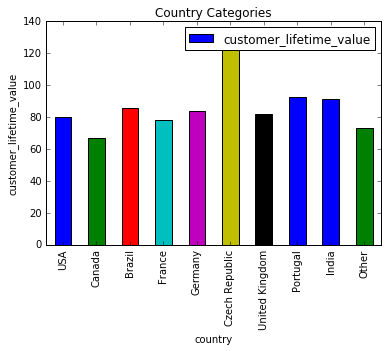

In [23]:
%matplotlib inline
plt.figure(figsize=(8, 6))
top_5 = df.head(5)
df.plot.bar(x='country', y='customer_lifetime_value')
plt.xlabel('country')
plt.ylabel('customer_lifetime_value')
plt.title('Country Categories')
plt.show()